# Estimación del estadio puberal de Tanner para añadir al M5 y afinarlo 

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pytensor  
from patsy import dmatrix


In [2]:
# read data
df = pd.read_csv("../data/clean/clean2_final_nutricion_salud.csv")

---

In [3]:
# Filtramos observaciones con datos completos de talla, edad y sexo
df_model = df[["talla_cm", "edad_anios_calc", "sexo", "peso_kg", "municipio", "id_persona"]].dropna()

# Establecemos 'id_persona' como índice del DataFrame
df_model = df_model.set_index("id_persona")

# Codificamos correctamente sexo 
# Recodeamos sexo: 0 = mujer, 1 = hombre
df_model["sexo"] = df_model["sexo"].map({2: 0, 1: 1})

# Confirmamos los tipos de variables y que no haya NAs
df_model.info()
df_model.describe()
df_model["sexo"].value_counts()
df_model["municipio"].nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 25355 entries, 100001_3 to 70336_4
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   talla_cm         25355 non-null  float64
 1   edad_anios_calc  25355 non-null  float64
 2   sexo             25355 non-null  int64  
 3   peso_kg          25355 non-null  float64
 4   municipio        25355 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2+ MB


177

In [4]:
# Codificamos cada municipio con un índice entero único (de 0 a n_grupos - 1)
df_model["municipio_idx"] = pd.Categorical(df_model["municipio"]).codes

# Verificamos que se creó correctamente
df_model[["municipio", "municipio_idx"]].drop_duplicates().sort_values("municipio_idx").head()


,municipio,municipio_idx
id_persona,,
100001_3,1.0,0
11276_3,2.0,1
110044_5,3.0,2
100075_5,4.0,3
100121_6,5.0,4


---

In [5]:
# Centrar la edad y guardar la media: 
# Esto ayuda a que el intercepto sea interpretable (talla promedio en la edad media) y mejora la estabilidad numérica del muestreo.
edad_mean = df_model["edad_anios_calc"].mean()
df_model["edad_c"] = df_model["edad_anios_calc"] - edad_mean

print(f"Edad media en la muestra: {edad_mean:.3f} años")
df_model[["edad_anios_calc", "edad_c"]].head()


Edad media en la muestra: 6.266 años


,edad_anios_calc,edad_c
id_persona,,
100001_3,8.695414,2.429254
100006_6,11.211499,4.945339
100008_10,7.561944,1.295784
100009_3,6.277892,0.011732
100010_7,8.145106,1.878946


---

## Splines

In [6]:
# Construcción de B-splines cúbicos para la edad
# (A) Hiperparámetro de flexibilidad
df_spline = 5        # Empezamos con 5; luego probamos 6 o 7 si hace falta.

# (B) Matriz de B-splines cúbicos de la edad (sin intercepto)
X_spline = dmatrix(
    "bs(edad, df=df_spline, degree=3, include_intercept=False) - 1",
    {"edad": df_model["edad_anios_calc"].values},
    return_type="dataframe"
)

# (C) A NumPy para PyMC
X_s = X_spline.to_numpy()

# (D) Chequeo rápido
n_obs, n_s = X_s.shape
print("X_s shape:", X_s.shape)   # (n_obs, n_bases)


X_s shape: (25355, 5)


In [7]:
# Variable objetivo y predictores “clásicos”
y        = df_model["talla_cm"].to_numpy()
sexo     = df_model["sexo"].to_numpy().astype(int)  # 0 = mujer, 1 = hombre

# Edad centrada (importante para estabilidad y para interpretar el intercepto)
edad_c   = (df_model["edad_anios_calc"] - df_model["edad_anios_calc"].mean()).to_numpy()

# Índice entero de municipio por observación (0..n_muni-1)
muni_idx = df_model["municipio_idx"].to_numpy().astype(int)

# Tamaños
n_obs_chk = y.shape[0]
n_muni    = int(muni_idx.max()) + 1

# Chequeos
assert X_s.shape[0] == n_obs_chk, "X_s debe tener tantas filas como observaciones."
print(f"n_obs={n_obs_chk} | n_s(bases)={n_s} | n_muni={n_muni}")


n_obs=25355 | n_s(bases)=5 | n_muni=177


---

## Estimación estadio puberal Tanner con modelos latentes probabilísticos (LVPM)

Qué son los estadios Tanner?

Se usan clínicamente para evaluar el desarrollo físico en la pubertad, con 5 fases (Tanner 1 a 5), basadas en características sexuales secundarias: desarrollo mamario/genital y vello púbico. Son el “estándar de oro” en pediatría

### Teoría: Modelos latentes probabilísticos aplicados a Tanner

Un modelo latente parte de la idea de que, además de las variables que observamos (edad, sexo, talla, IMC), existe una **variable oculta** que no se mide directamente pero que explica parte del patrón en los datos.  
En el contexto de crecimiento infantil, esa variable oculta corresponde al **estadio puberal de Tanner (I–V)**.

1. Probabilidades de estadio
El modelo no asigna a cada niño un estadio fijo, sino que estima **probabilidades** para cada uno de los cinco estadios.  
Estas probabilidades dependen de características observadas como la edad, el sexo y el IMC.  
Ejemplo: un niño de 13 años podría tener:  
- 10% Tanner II  
- 40% Tanner III  
- 50% Tanner IV  

2. Distribuciones por estadio
Cada estadio Tanner tiene su propia **distribución de talla esperada**.  
- Tanner I: estaturas más bajas.  
- Tanner V: estaturas más altas.  
- Los estadios intermedios representan el crecimiento acelerado del estirón puberal.  

De esta forma, si un niño está en Tanner III, se espera que su talla se distribuya alrededor de un valor típico para ese estadio, con cierta variabilidad natural.

3. Mezcla probabilística
Como no sabemos en qué estadio se encuentra exactamente cada niño, el modelo combina todas las distribuciones ponderadas por las probabilidades:  

**Prob(talla) = Prob(Tanner I)·Distribución I + Prob(Tanner II)·Distribución II + ... + Prob(Tanner V)·Distribución V**

Esto refleja que la talla observada no proviene de una única categoría fija, sino de una mezcla que captura la **incertidumbre** del estado puberal.

4. Interpretación
- Las **probabilidades** responden a: “¿Qué tan probable es que este niño esté en cada estadio Tanner?”.  
- Las **distribuciones por estadio** responden a: “Si el niño estuviera en este estadio, ¿cuál sería la talla típica?”.  
- La **mezcla final** responde a: “Dada su edad y características, ¿cómo se distribuye la talla observada?”.  

5. Ventajas
- No fuerza a clasificar en un único estadio.  
- Captura la incertidumbre en edades de transición.  
- Representa mejor la heterogeneidad real del crecimiento que un modelo lineal simple.  
- Permite aproximar el Tanner aunque no haya mediciones clínicas directas.


---

 **Añadir una variable latente puberal al M5 primero con 2 estados: PRE y POST**

In [8]:
# --- Preparación mínima (solo si no está corrido arriba) ---

y        = df_model["talla_cm"].to_numpy()
sexo     = df_model["sexo"].map({2:0, 1:1}).to_numpy().astype(int)  # 0=mujer, 1=hombre
edad     = df_model["edad_anios_calc"].to_numpy()
edad_c   = edad - edad.mean()
edad_cs  = edad_c / (edad_c.std() + 1e-8)

muni_idx = pd.Categorical(df_model["municipio"]).codes.astype(int)
n_muni   = int(muni_idx.max()) + 1

# X_s: tu matriz de splines tiene que ser array float
X_s = X_s.astype(float)

# Chequeos de tamaño
n_obs = y.shape[0]
n_s   = X_s.shape[1]
assert X_s.shape[0] == n_obs, "X_s debe tener tantas filas como observaciones."
assert sexo.shape[0] == n_obs and edad_cs.shape[0] == n_obs and muni_idx.shape[0] == n_obs, "Vectores mal alineados."

print(f"n_obs={n_obs} | n_s={n_s} | n_muni={n_muni}")


n_obs=25355 | n_s=5 | n_muni=177


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_53269/758676489.py:4: RuntimeWarning: invalid value encountered in cast
  sexo     = df_model["sexo"].map({2:0, 1:1}).to_numpy().astype(int)  # 0=mujer, 1=hombre


Para cada observación, el modelo calcula una probabilidad de POST: p_post (entre 0 y 1).

p_post se modela con una logística que aumenta con la edad (y puede depender de sexo).

Parámetros:

g0: intercepto (prob POST en la edad media).

g_ed: cuánto sube la prob POST cuando la edad sube 1 desviación estándar.

g_sx: cambio de prob POST por ser hombre (opcional).

La talla no “elige” PRE o POST; en cambio, se modela como mezcla:

Componente PRE: media = mu_base + delta_pre

Componente POST: media = mu_base + delta_post

Para que los dos “ajustes” sean identificables, les imponemos suma cero:
delta_pre + delta_post = 0.
Así, si delta_post > 0 ⇒ POST está por encima de la base; PRE, por debajo.

# Muestreo estratificado

Tarda 12+ horas en correr, vamos a trabajar con una muestra hasta tener el modelo. 
Necesitamos hacer muestreo estratificado para no tener datos desbalanceados --> muestrear por estratos y proporcional al tamaño de los grupos

In [9]:
# Asegura sexo binario 0/1
if set(df_model["sexo"].unique()) - {0,1}:
    df_model = df_model.copy()
    df_model["sexo"] = df_model["sexo"].map({2:0, 1:1})

# Mantén solo columnas clave y sin NA
cols_req = ["talla_cm", "edad_anios_calc", "sexo", "municipio"]
df_base = df_model[cols_req].dropna().copy()

print("Filas disponibles:", len(df_base))
assert set(df_base["sexo"].unique()) <= {0,1}, "Columna 'sexo' debe ser 0/1."


Filas disponibles: 25355


In [10]:
# 1) Bins sin vacíos (hasta 13 años)
age_bins   = [-np.inf, 5, 7, 9, 11, 13]
age_labels = [f"({age_bins[i]},{age_bins[i+1]}]" for i in range(len(age_bins)-1)]

df_b = df_model[["talla_cm","edad_anios_calc","sexo","municipio"]].dropna().copy()
if set(df_b["sexo"].unique()) - {0,1}:
    df_b["sexo"] = df_b["sexo"].map({2:0, 1:1})

df_b["edad_bin"] = pd.cut(df_b["edad_anios_calc"], bins=age_bins, labels=age_labels, include_lowest=True)

# 2) Distribución original 
dist_orig = (df_b
    .groupby(["sexo","edad_bin"], observed=True)
    .size().rename("n").reset_index())

print("Distribución original por estrato (sexo x edad_bin):")
print(dist_orig.pivot(index="edad_bin", columns="sexo", values="n").fillna(0))


Distribución original por estrato (sexo x edad_bin):
sexo         0     1
edad_bin            
(-inf,5]  4676  4788
(5,7]     2310  2268
(7,9]     2455  2468
(9,11]    2183  2273
(11,13]    961   973


In [11]:
# === A. Muestreo estratificado exacto con scikit-learn === explicación de CHAT GPT
# Idea: queremos una SUBMUESTRA de tamaño N_SUB que conserve, lo mejor posible,
#       las proporciones originales de cada ESTRATO. Un "estrato" es una
#       combinación de variables (aquí: SEXO × RANGO DE EDAD).

from sklearn.model_selection import StratifiedShuffleSplit

N_SUB = 6000  # Tamaño deseado de la submuestra (ajustable)

# 1) Definimos la "etiqueta de estrato" para cada fila.
#    • Unimos sexo y el bin de edad en un string, por ejemplo: "0_(9,11]" o "1_(7,9]"
#    • Esto le dice al algoritmo en qué estrato está cada observación.
estrato = df_b["sexo"].astype(str) + "_" + df_b["edad_bin"].astype(str)

# 2) Creamos el "divisor estratificado".
#    • n_splits=1: queremos una sola partición (no un k-fold).
#    • test_size=N_SUB: el TAMAÑO del subconjunto que sacaremos (aquí "test" es la submuestra).
#    • random_state=42: semilla para que el resultado sea reproducible.
sss = StratifiedShuffleSplit(n_splits=1, test_size=N_SUB, random_state=42)

# 3) Ejecutamos el split.
#    • sss.split(X, y) recibe:
#         - X: la tabla completa (no se usa su contenido, solo el tamaño).
#         - y: las etiquetas de estrato (aquí 'estrato').
#    • Devuelve dos arreglos de índices: (idx_train, idx_test).
#      Usaremos idx_test como nuestra SUBMUESTRA, porque le dijimos que "test_size = N_SUB".
_, idx_sub = next(sss.split(df_b, estrato))

# 4) Extraemos la submuestra usando los índices calculados.
#    • .iloc[idx_sub] selecciona esas filas.
#    • .copy() para tener un DataFrame independiente (evita advertencias de pandas).
df_sub = df_b.iloc[idx_sub].copy()

# 5) Revisamos tamaño y distribución de la submuestra.
#    • Debe salir (N_SUB, n_columnas).
#    • La distribución por (sexo × edad_bin) debería ser MUY parecida a la original.
print("Submuestra final:", df_sub.shape)

# observed=True: usa solo categorías que aparecen (evita warning de pandas).
print(df_sub.groupby(["sexo","edad_bin"], observed=True).size())


Submuestra final: (6000, 5)
sexo  edad_bin
0     (-inf,5]    1106
      (5,7]        547
      (7,9]        581
      (9,11]       517
      (11,13]      227
1     (-inf,5]    1133
      (5,7]        537
      (7,9]        584
      (9,11]       538
      (11,13]      230
dtype: int64


In [12]:
# ====== A) Reindexar municipios y preparar arrays ======

# 1) Reindexar municipios (solo los que aparecen en la SUBMUESTRA)
df_sub = df_sub.copy()
df_sub["municipio_idx_sub"] = pd.Categorical(df_sub["municipio"]).codes

# 2) Arreglos NumPy que usará PyMC
y_sub     = df_sub["talla_cm"].to_numpy().astype(float)          # variable objetivo (cm)
edad_sub  = df_sub["edad_anios_calc"].to_numpy().astype(float)   # edad (años)
sexo_sub  = df_sub["sexo"].to_numpy().astype(int)                # 0 = mujer, 1 = hombre
muni_sub  = df_sub["municipio_idx_sub"].to_numpy().astype(int)   # índice municipal 0..J-1

# 3) Versiones centrada y estandarizada de la edad
#    - edad_c_sub: centrada => intercepto ~ talla a la edad media
#    - edad_cs_sub: centrada + estandarizada => estable numéricamente para la compuerta (logística)
edad_c_sub  = edad_sub - edad_sub.mean()
edad_cs_sub = (edad_c_sub - edad_c_sub.mean()) / edad_c_sub.std()

# 4) Chequeos rápidos (defensivos)
assert set(np.unique(sexo_sub)).issubset({0,1}), "Sexo debe ser 0/1."
n_muni_sub = df_sub["municipio_idx_sub"].nunique()
assert muni_sub.min() >= 0 and muni_sub.max() < n_muni_sub, "municipio_idx_sub fuera de rango."

print(f"n_obs={len(y_sub)} | n_muni_sub={n_muni_sub}")
print("Arrays listos: y_sub, edad_sub, sexo_sub, edad_c_sub, edad_cs_sub, muni_sub")


n_obs=6000 | n_muni_sub=177
Arrays listos: y_sub, edad_sub, sexo_sub, edad_c_sub, edad_cs_sub, muni_sub


In [13]:
# ====== B) B-splines cúbicos para edad ======

# Grados de libertad (ajústalo: 5 suele ir bien para modo rápido)
df_spline = 5

# Construcción de la matriz de bases spline sobre la edad OBSERVADA en la submuestra
X_spline_sub = dmatrix(
    f"bs(edad, df={df_spline}, degree=3, include_intercept=False) - 1",
    {"edad": edad_sub},
    return_type="dataframe"
)

# A NumPy (PyMC espera arrays)
X_s_sub = X_spline_sub.to_numpy()

# Tamaños para control
n_obs_sub, n_s_sub = X_s_sub.shape
print("X_s_sub shape =", X_s_sub.shape)    # (n_obs_sub, n_bases)

# Chequeo: debe haber una FILA por observación
assert n_obs_sub == len(y_sub), "X_s_sub debe tener n_obs_sub filas (una por observación)."


X_s_sub shape = (6000, 5)


# Modelo M6 (M5 + latente PRE/POST) simple y estable

In [ ]:

# 0.1) Copia de trabajo y codificación de municipio 0..J-1
df_sub = df_sub.copy()
df_sub["municipio_idx_sub"] = pd.Categorical(df_sub["municipio"]).codes

# 0.2) Arrays numpy alineados (mismo orden/longitud)
y_sub       = df_sub["talla_cm"].to_numpy().astype(float)
sexo_sub    = df_sub["sexo"].to_numpy().astype(int)                     # 0=mujer, 1=hombre
muni_sub    = df_sub["municipio_idx_sub"].to_numpy().astype(int)

# 0.3) Edad centrada y estandarizada (para compuerta logística)
edad_c_sub  = (df_sub["edad_anios_calc"] - df_sub["edad_anios_calc"].mean()).to_numpy()
edad_z_su   = (edad_c_sub / df_sub["edad_anios_calc"].std()).astype(float)  # <- USAR ESTE NOMBRE SIEMPRE

# 0.4) Matriz de B-splines (curva flexible por edad)
#    - df=6 suele ser buen punto de partida; si ondula mucho bajamos a 5; si le falta flexibilidad subimos a 7
X_s_sub = dmatrix("bs(x, df=6, degree=3, include_intercept=False)",
                  {"x": edad_c_sub}, return_type="dataframe").to_numpy().astype(float)

# 0.5) Tamaños básicos
n_obs_sub  = y_sub.shape[0]
n_s_sub    = X_s_sub.shape[1]
n_muni_sub = int(df_sub["municipio_idx_sub"].nunique())

# 0.6) Chequeos
assert n_obs_sub == sexo_sub.shape[0] == edad_z_su.shape[0] == muni_sub.shape[0] == X_s_sub.shape[0]
print(f"OK insumos | n_obs={n_obs_sub} | n_s={n_s_sub} | n_muni={n_muni_sub}")


OK insumos | n_obs=6000 | n_s=7 | n_muni=177


In [ ]:
# ===== CHUNK 1: Modelo M6 simple (splines + RE municipio + compuerta PRE/POST) =====

with pm.Model() as modelo_m6_sub:
    # (1) PRIORS globales (cm)
    beta_0        = pm.Normal("beta_0", 125, 10)   # talla promedio a edad media (sexo=0)
    beta_sexo     = pm.Normal("beta_sexo", 3, 2)   # diferencia H vs M
    beta_edad_sex = pm.Normal("beta_edad_sex", 0, 1)  # interacción lineal suave edad×sexo

    # (2) SPLINES (curva de edad) con regularización suave 
    w_s   = pm.Normal("w_s", 0, 0.5, shape=n_s_sub)     # sd=0.5 → más estable
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))

    # (3) EFECTO ALEATORIO por municipio (solo INTERCEPTO, no-centrado) NO TIENE PENDIENTE este modelo 
    sd_a0 = pm.HalfNormal("sd_a0", 5)
    z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni_sub)
    a0    = pm.Deterministic("a0", sd_a0 * z_a0)

    # (4) MEDIA base (sin pubertad)
    mu_base = (
        beta_0
      + beta_sexo * sexo_sub
      + f_edad
      + a0[muni_sub]
      + beta_edad_sex * (edad_c_sub * sexo_sub)
    )

    # (5) COMPUERTA puberal (K=2: PRE/POST) usando edad_z_su (centrada + estandarizada)
    g0   = pm.Normal("g0", 0, 2)
    g_ed = pm.Normal("g_ed", 1.5, 1)     # esperamos > 0 (prob POST sube con edad)
    g_sx = pm.Normal("g_sx", 0, 1)       # puedes fijarlo a 0 si quieres simplificar

    logit_post = g0 + g_ed*edad_z_su + g_sx*sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))            # (n_obs,)
    W          = pm.Deterministic("W", pm.math.stack([1 - p_post, p_post], axis=1)) # (n_obs,2)

    # (6) DELTAS con suma-cero (evita duplicar intercepto entre componentes)
    delta_raw = pm.Normal("delta_raw", 0, 1.5, shape=2)   # prior algo apretado → más estable
    delta     = pm.Deterministic("delta", delta_raw - delta_raw.mean())  # PRE + POST = 0

    # Medias por estado (col 0=PRE, col 1=POST)
    mu_comp = pm.Deterministic(
        "mu_comp",
        pm.math.stack([mu_base + delta[0], mu_base + delta[1]], axis=1)
    )

    # (7) LIKELIHOOD robusta: mezcla de 2 Student-t
    nu    = pm.Exponential("nu", 1/10)       # g.l. (colas)
    sigma = pm.HalfNormal("sigma_obs", 5)    # escala

    comp_pre  = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 0], sigma=sigma)
    comp_post = pm.StudentT.dist(nu=nu, mu=mu_comp[:, 1], sigma=sigma)

    talla_obs = pm.Mixture(
        "talla_obs",
        w=W, comp_dists=[comp_pre, comp_post],
        observed=y_sub
    )

    # (8) MUESTREO (parámetros prudentes y estables)
    idata_m6_sub = pm.sample(
        draws=800, tune=1000,
        chains=2, cores=1,
        target_accept=0.98,
        init="jitter+adapt_diag",
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, z_a0, g0, g_ed, g_sx, delta_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 800 draw iterations (2_000 + 1_600 draws total) took 302 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# ===== CHUNK 2: PPC y anexarlo a idata =====
with modelo_m6_sub:
    ppc_m6 = pm.sample_posterior_predictive(
        idata_m6_sub,               # usa las muestras ya entrenadas
        return_inferencedata=True,
        random_seed=42
    )

# Anexar PPC al InferenceData 
idata_m6_sub.extend(ppc_m6)

print("Grupos en idata_m6_sub:", list(idata_m6_sub._groups))


Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Grupos en idata_m6_sub: ['posterior', 'posterior_predictive', 'log_likelihood', 'sample_stats', 'observed_data']


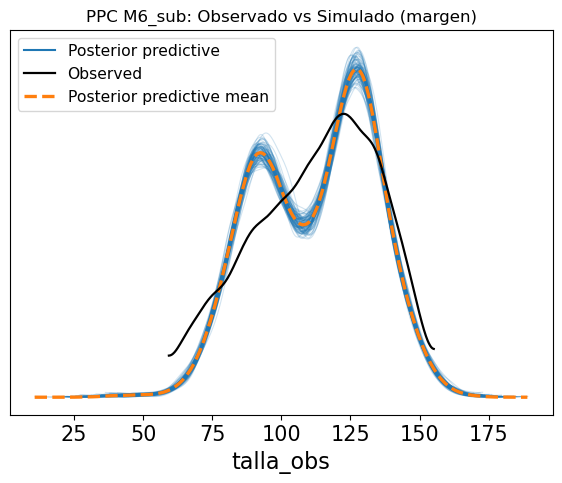

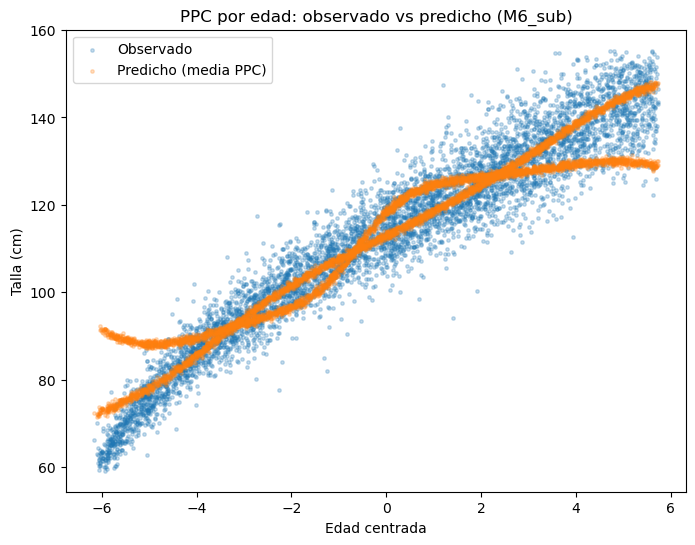

In [ ]:
# ===== CHUNK 3: Gráficos PPC =====

# 3.1) Overlay KDE observado vs simulado (margen)
az.plot_ppc(
    idata_m6_sub,
    kind="kde",
    data_pairs={"talla_obs": "talla_obs"},
    num_pp_samples=100,
    figsize=(7,5)
)
plt.title("PPC M6_sub: Observado vs Simulado (margen)"); plt.show()

# 3.2) PPC por edad: nube Observado vs Predicho (media del PPC por observación)
y_pred_mean = (
    idata_m6_sub.posterior_predictive["talla_obs"]
    .stack(draws=("chain","draw")).mean("draws").values
)

plt.figure(figsize=(8,6))
plt.scatter(edad_c_sub, y_sub,       s=6, alpha=0.25, label="Observado")
plt.scatter(edad_c_sub, y_pred_mean, s=6, alpha=0.25, label="Predicho (media PPC)")
plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
plt.title("PPC por edad: observado vs predicho (M6_sub)")
plt.legend(); plt.show()


In [ ]:
# ===== CHUNK 4: Diagnóstico y guardado =====
summ = az.summary(
    idata_m6_sub,
    var_names=["beta_0","beta_sexo","beta_edad_sex",
               "g0","g_ed","g_sx","delta","sd_a0","sigma_obs","nu","w_s"],
    round_to=2
)
display(summ.sort_values("r_hat", ascending=False).head(12))

# - g_ed > 0  → la probabilidad de POST aumenta con la edad (biológicamente correcto)
# - delta[1] > 0 y delta[0] < 0  → POST más alto que PRE
# - r_hat ~ 1.00–1.01 OK; si > 1.05, sube target_accept a 0.99, baja sd de w_s a 0.3 o reduce df de splines

# (Opcional) Guardar a disco para no perderlo si reinicias kernel
# idata_m6_sub.to_netcdf("idata_m6_sub.nc")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sd_a0,0.88,0.29,0.37,1.46,0.02,0.01,234.53,250.52,1.01
beta_0,108.27,0.63,107.13,109.43,0.02,0.02,1140.52,1058.73,1.00
nu,11.91,2.41,7.99,16.29,0.07,0.08,1359.43,1015.18,1.00
w_s[5],7.07,0.45,6.25,7.87,0.01,0.01,2375.21,1498.44,1.00
w_s[4],2.37,0.43,1.57,3.19,0.01,0.01,1361.08,1112.77,1.00
w_s[3],1.47,0.48,0.58,2.34,0.01,0.01,1082.82,1288.22,1.00
w_s[2],3.63,0.44,2.82,4.51,0.01,0.01,1979.79,1138.19,1.00
w_s[1],-8.81,0.50,-9.81,-7.87,0.01,0.01,1449.16,1122.18,1.00
w_s[0],-0.04,0.51,-0.94,0.99,0.01,0.01,1780.31,1107.28,1.00
sigma_obs,8.00,0.15,7.71,8.28,0.00,0.00,1167.41,1112.61,1.00


---

## Intentando mejorar M6 

In [21]:

def quick_ppc_plots(idata, x_age, y_obs, title=""):
    # KDE margen
    az.plot_ppc(
        idata, kind="kde",
        data_pairs={"talla_obs": "talla_obs"},
        num_pp_samples=100, figsize=(5.2,4)
    ); plt.title(f"PPC margen {title}"); plt.show()

    # Media PPC por edad (suavizado simple)
    y_ppc = idata.posterior_predictive["talla_obs"].stack(s=("chain","draw")).values
    y_hat = y_ppc.mean(axis=1)
    plt.figure(figsize=(6.2,4.2))
    plt.scatter(x_age, y_obs, s=6, alpha=.15, label="Observado")
    plt.scatter(x_age, y_hat, s=8, alpha=.6, label="Predicho (media PPC)")
    plt.xlabel("Edad centrada"); plt.ylabel("Talla (cm)")
    plt.title(f"PPC por edad {title}"); plt.legend(); plt.show()

def loo_report(idata, label=""):
    loo = az.loo(idata, pointwise=False)
    print(f"{label}  elpd_loo={loo.elpd_loo:.2f}  p_loo={loo.p_loo:.2f}  SE={loo.se:.2f}")
    # Pareto-k
    pk = az.loo(idata, pointwise=True).pareto_k.values
    k_bad  = np.sum((pk>0.7) & (pk<=1.0))
    k_vbad = np.sum(pk>1.0)
    print(f"Pareto k: >0.7={k_bad}  >1.0={k_vbad}  de {len(pk)}")


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_s, beta_0, sd_a0, z_a0, g0, g_ed, g_sx, delta_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 700 tune and 700 draw iterations (1_400 + 1_400 draws total) took 339 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[M6a priors]  elpd_loo=-22526.74  p_loo=44.03  SE=51.81
Pareto k: >0.7=0  >1.0=0  de 6000


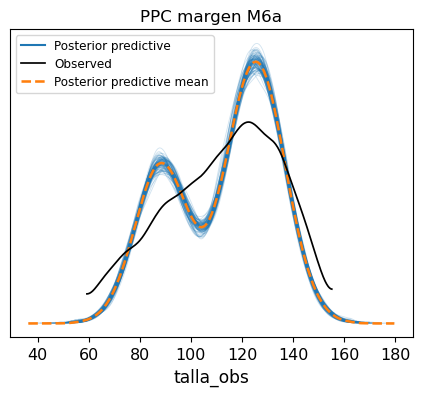

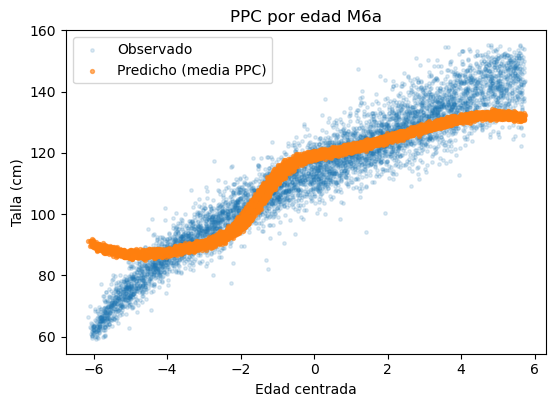

In [ ]:
with pm.Model() as modelo_m6a:
    # 1) Splines base
    w_s = pm.Normal("w_s", 0, 0.5, shape=n_s_sub)
    f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))

    # 2) Intercepto global + RE municipal (solo intercepto)
    beta_0 = pm.Normal("beta_0", 125, 10)
    sd_a0  = pm.HalfNormal("sd_a0", 5)
    z_a0   = pm.Normal("z_a0", 0, 1, shape=n_muni_sub)
    a0     = pm.Deterministic("a0", sd_a0 * z_a0)

    mu_base = beta_0 + f_edad + a0[muni_sub]

    # 3) Compuerta PRE/POST
    g0   = pm.Normal("g0", 0, 2)
    g_ed = pm.Normal("g_ed", 1.0, 0.5)   # <-- más conservador
    g_sx = pm.Normal("g_sx", 0, 0.5)     # <-- más conservador

    logit_post = g0 + g_ed*edad_z_sub + g_sx*sexo_sub
    p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))
    W          = pm.Deterministic("W", pm.math.stack([1 - p_post, p_post], axis=1))

    # Deltas suma-cero
    delta_raw = pm.Normal("delta_raw", 0, 1, shape=2)   # <-- encogido
    delta     = pm.Deterministic("delta", delta_raw - delta_raw.mean())

    mu_comp = pm.Deterministic(
        "mu_comp",
        pm.math.stack([mu_base + delta[0], mu_base + delta[1]], axis=1)
    )

    # 4) Likelihood (misma sigma para ambos)
    nu    = pm.Exponential("nu", 1/10)
    sigma = pm.HalfNormal("sigma_obs", 5)
    comp_pre  = pm.StudentT.dist(nu=nu, mu=mu_comp[:,0], sigma=sigma)
    comp_post = pm.StudentT.dist(nu=nu, mu=mu_comp[:,1], sigma=sigma)

    talla_obs = pm.Mixture("talla_obs", w=W, comp_dists=[comp_pre, comp_post], observed=y_sub)

    idata_m6a = pm.sample(
        draws=700, tune=700, chains=2, cores=1,
        target_accept=0.98, init="jitter+adapt_diag",
        random_seed=42, return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )
    ppc_m6a = pm.sample_posterior_predictive(idata_m6a, return_inferencedata=True, random_seed=42)

idata_m6a.extend(ppc_m6a)
loo_report(idata_m6a, "[M6a priors]")
quick_ppc_plots(idata_m6a, edad_c_sub, y_sub, title="M6a")


In [24]:
az.summary(
    idata_m6a,
    var_names=["beta_0","g0","g_ed","g_sx","delta","sd_a0","sigma_obs","nu","w_s"],
    round_to=2
).sort_values("r_hat").head(12)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,106.98,0.60,105.86,108.17,0.02,0.02,1197.02,871.13,1.0
g0,3.20,0.21,2.77,3.56,0.01,0.01,1655.39,1285.54,1.0
g_ed,7.59,0.28,7.02,8.06,0.01,0.01,2549.57,783.70,1.0
g_sx,0.51,0.18,0.20,0.86,0.00,0.00,2275.02,1076.30,1.0
delta[0],-15.77,0.19,-16.16,-15.44,0.00,0.00,1724.65,1142.24,1.0
delta[1],15.77,0.19,15.44,16.16,0.00,0.00,1724.65,1142.24,1.0
sigma_obs,9.88,0.12,9.67,10.12,0.00,0.00,1381.20,1097.28,1.0
nu,63.56,17.17,34.97,94.18,0.40,0.55,1871.61,904.97,1.0
w_s[0],-0.06,0.51,-1.05,0.88,0.01,0.01,1385.12,860.05,1.0
w_s[1],-8.14,0.52,-9.08,-7.15,0.01,0.01,1860.09,1226.75,1.0


In [ ]:
# # ================================
# # M6b: M5 + variable latente puberal (2 estados: PRE vs POST)
# # ================================
# with pm.Model() as modelo_m6b:
#     # --- (1) PRIORS GLOBALES ---
#     beta_0        = pm.Normal("beta_0", 125, 10)  # talla promedio (edad media, sexo=0)
#     beta_sexo     = pm.Normal("beta_sexo", 3, 2)  # diferencia hombre vs mujer
#     beta_edad_sex = pm.Normal("beta_edad_sex", 0, 2)  # interacción edad×sexo global

#     # --- (2) SPLINES DE EDAD ---
#     # w_s controla la forma de la curva (más flexible que un polinomio)
#     w_s = pm.Normal("w_s", 0, 1.0, shape=n_s_sub)
#     f_edad = pm.Deterministic("f_edad", pm.math.dot(X_s_sub, w_s))

#     # --- (3) EFECTOS ALEATORIOS MUNICIPALES ---
#     # Cada municipio tiene su propia curva: intercepto + pendiente
#     sd_a0 = pm.HalfNormal("sd_a0", 5)   # sd de interceptos
#     sd_a1 = pm.HalfNormal("sd_a1", 2)   # sd de pendientes
#     z_a0  = pm.Normal("z_a0", 0, 1, shape=n_muni_sub)
#     z_a1  = pm.Normal("z_a1", 0, 1, shape=n_muni_sub)

#     a0 = pm.Deterministic("a0", sd_a0 * z_a0)  # interceptos municipales
#     a1 = pm.Deterministic("a1", sd_a1 * z_a1)  # pendientes municipales

#     # --- (4) MEDIA BASE (sin pubertad) ---
#     mu_base = (
#         beta_0
#         + beta_sexo * sexo_sub
#         + f_edad
#         + a0[muni_sub]
#         + a1[muni_sub] * edad_c_sub
#         + beta_edad_sex * (edad_c_sub * sexo_sub)
#     )

#     # --- (5) VARIABLE LATENTE PUBERAL (PRE vs POST) ---
#     # p_post = probabilidad de estar en POST-pubertad
#     g0   = pm.Normal("g0", 0, 2)        # intercepto del logit
#     g_ed = pm.Normal("g_ed", 1.5, 1)    # efecto de edad (esperado >0)
#     g_sx = pm.Normal("g_sx", 0, 1)      # efecto de sexo (puede ser pequeño)

#     logit_post = g0 + g_ed * edad_z_sub + g_sx * sexo_sub
#     p_post     = pm.Deterministic("p_post", pm.math.sigmoid(logit_post))

#     # Matriz de pesos [Prob(PRE), Prob(POST)] para cada observación
#     W = pm.Deterministic("W", pm.math.stack([1 - p_post, p_post], axis=1))

#     # --- (6) AJUSTES DE CADA ESTADO (delta con suma cero) ---
#     delta_raw = pm.Normal("delta_raw", 0, 2, shape=2)
#     delta     = pm.Deterministic("delta", delta_raw - delta_raw.mean())
#     # delta[0] = PRE, delta[1] = POST (comparten referencia para no duplicar intercepto)

#     mu_comp = pm.Deterministic(
#         "mu_comp",
#         pm.math.stack([
#             mu_base + delta[0],  # media en PRE
#             mu_base + delta[1]   # media en POST
#         ], axis=1)
#     )

#     # --- (7) LIKELIHOOD ROBUSTA (mixtura Student-t) ---
#     nu    = pm.Exponential("nu", 1/10)
#     sigma = pm.HalfNormal("sigma_obs", 5)

#     comp_pre  = pm.StudentT.dist(nu=nu, mu=mu_comp[:,0], sigma=sigma)
#     comp_post = pm.StudentT.dist(nu=nu, mu=mu_comp[:,1], sigma=sigma)

#     talla_obs = pm.Mixture("talla_obs", w=W, comp_dists=[comp_pre, comp_post], observed=y_sub)

#     # --- (8) MUESTREO ---
#     idata_m6b = pm.sample(
#         draws=1000, tune=1000,
#         chains=4, cores=1,
#         target_accept=0.99,
#         init="jitter+adapt_diag",
#         random_seed=42,
#         return_inferencedata=True,
#         idata_kwargs={"log_likelihood": True}
#     )

#     # Posterior Predictive
#     ppc_m6b = pm.sample_posterior_predictive(
#         idata_m6b, model=modelo_m6b, return_inferencedata=True, random_seed=42
#     )
#     idata_m6b.extend(ppc_m6b)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, beta_sexo, beta_edad_sex, w_s, sd_a0, sd_a1, z_a0, z_a1, g0, g_ed, g_sx, delta_raw, nu, sigma_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27084 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [talla_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
# az.summary(
#     idata_m6b,
#     var_names=["beta_0","g0","g_ed","g_sx","delta","sd_a0","sigma_obs","nu","w_s"],
#     round_to=2
# ).sort_values("r_hat").head(12)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,9.87,1.40,7.33,12.41,0.02,0.03,3297.56,3167.41,1.00
w_s[0],-0.17,1.02,-1.99,1.85,0.02,0.02,4573.30,2795.88,1.00
sd_a0,1.45,0.18,1.13,1.79,0.01,0.00,191.42,1582.26,1.03
g_sx,-0.68,0.45,-1.41,0.22,0.12,0.06,16.58,69.79,1.16
w_s[4],1.45,0.85,0.01,3.13,0.30,0.04,8.46,52.70,1.39
w_s[5],-0.95,1.01,-2.75,0.91,0.36,0.01,8.21,117.10,1.41
beta_0,108.27,1.63,105.33,111.20,0.59,0.06,7.79,58.70,1.45
w_s[1],3.96,1.10,1.96,5.86,0.41,0.01,7.84,101.28,1.45
w_s[6],-4.23,1.17,-6.27,-2.16,0.46,0.01,6.98,107.43,1.56
sigma_obs,4.36,0.38,3.88,4.89,0.18,0.01,6.15,121.71,1.72


TARDA 8 + HORAS Y CONVERGENCIA HORRIBLE

---

## Sandbox

---